## 📊 **Graphic Profile Identification and Morphological Characterization - Section 7.1**

This notebook contains the code for Section 7.1 of the article, where we conduct a PCA to our character prototypes to determine the Graphic Profiles (GPs) present in the dataset, and to describe/characterize them with regards to the literature . ✍️ The methodology is outlined and illustrated in Section 6.

---

### 🧑‍💻 **For the statistical analysis of the Graphic Profiles (GPs),**  
Please refer to the notebook titled **"statistical_analysis.ipynb"**. This notebook dives deeper into the scribal habitus (abbreviative profile and line management strategies) of the graphic profiles. 🔍

---

### 📑 **Interpretation of Results**  
For a detailed interpretation of the results, please refer to the **Discussion in Section 7.1** of the article, where we contextualize the morphological analysis. The notebook follows the order of the results presented in the paper, with references to the relevant subsections, tables, and figures for easy cross-referencing.

---

### 💾 **File Outputs**  
All generated tables and figures are saved in the `./results/graphic_profiles` folder. Feel free to explore these files for further analysis and presentation! 📂

---

### ❗**Use on your data**
If you plan to use this script for your own data, please remember to cite the article and the code! 📚📝
Additionally, ensure that your data structure matches the one used here (annotation.json, images, metadata) for seamless integration.

## 🔧 **Imports**

In [18]:
#base imports
import os
import re
import math
import json
import numpy as np
import pandas as pd
from pathlib import Path


#pca imports 
from skimage.io import imread
from skimage.transform import resize
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

#visualisation imports
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import LinearSegmentedColormap, Normalize, LogNorm
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.lines import Line2D

#LateX font style 
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

plt.rcParams['text.usetex'] = True

In [38]:
from notebook.services.config import ConfigManager

cm = ConfigManager()

# Set the new value for iopub_data_rate_limit
cm.update('NotebookApp', {'iopub_data_rate_limit': 10000000})  # Set to 10 MB/s, for example

{'iopub_data_rate_limit': 10000000, 'rate_limit_window': 3.0}

## 📁 **Base paths**

In [27]:
# Base path: current working directory (suitable for Jupyter)
BASE_DIR = Path.cwd()

# Define relative paths using your original variable names
prototype_folder = BASE_DIR / ".." / "prototypes"
transcribe_json_path = prototype_folder / "transcribe.json"

annotation_json_path = BASE_DIR / ".." / "dataset" / "annotation.json"

pca_dir = BASE_DIR / ".." / "results" / "graphic_profiles"

# Optional extras (if you're using them elsewhere)
stats_dir = BASE_DIR / ".." / "results" / "statistical_analysis"
junicode_font_path = BASE_DIR / ".." / "Junicode.ttf"

## 0a. Helper Functions: Image Loading and Visualization 🖼️👀

In [28]:
# Function to parse character range or single number input
def parse_characters_range(*characters_ranges):
    result = []
    
    for characters_range in characters_ranges:
        if isinstance(characters_range, str):
            if '-' in characters_range:
                start, end = map(int, characters_range.split('-'))
                result.extend(range(start, end + 1))
            elif characters_range.isdigit():
                result.append(int(characters_range))
            else:
                raise ValueError("Invalid format. Use a number or a range in 'start-end' format.")
        elif isinstance(characters_range, list):
            result.extend(int(num) for num in characters_range)
        else:
            raise TypeError("Input should be a string (with a range or single number) or a list.")

    return sorted(set(result))  # Sorting and removing duplicates if needed

# Load images from directory
def load_images(prototype_folder, characters_range):
    suffixes = parse_characters_range(characters_range)
    print(f"Parsed image name: {suffixes}")

    all_images = []
    labels = []
    image_shape = None

    for folder_name in os.listdir(prototype_folder):
        folder_path = os.path.join(prototype_folder, folder_name)

        if os.path.isdir(folder_path):
            for filename in os.listdir(folder_path):
                if any(filename.endswith(f'{suffix}.png') for suffix in suffixes):
                    img_path = os.path.join(folder_path, filename)
                    img = imread(img_path, as_gray=True)

                    # Set the image shape based on the first image
                    if image_shape is None:
                        image_shape = img.shape  # Store the shape of the first image
                        image_shape = (48,48)

                    img = resize(img, image_shape)  # Resize all images to the same shape
                    img = img.flatten()  # Flatten the image to a 1D vector

                    all_images.append(img)
                    labels.append(folder_name)

    if image_shape is None:
        raise ValueError("No images found in the specified directory.")

    return np.array(all_images), labels, image_shape


def sort_key(label, folio_mapping):
    """
    Custom sort key using folio associated to the label.
    Sorts numerically where possible.
    """
    folio = folio_mapping.get(label, 'Unknown')
    return [int(text) if text.isdigit() else text for text in re.split(r'(\d+)', folio)]

def pca_prototypes(images, labels, folio_mapping, save_path=None):
    """
    Display the images with their mapped folio labels (based on labels),
    and save the figure to a file if a save path is provided.
    
    Parameters:
    - images (list or np.array): List of images (flattened).
    - labels (list): Folder names (already passed).
    - folio_mapping (dict): Mapping from image filename (without .png) to folio.
    - save_path (str, optional): Where to save the figure.
    """

    # Infer image shape
    if images.ndim == 2:
        side_length = int(np.sqrt(images.shape[1]))
        image_shape = (side_length, side_length)
    else:
        raise ValueError("Images should be flattened.")

    # Sort the images and labels together
    image_label_pairs = [(images[i], labels[i]) for i in range(len(images))]
    image_label_pairs.sort(key=lambda x: sort_key(x[1], folio_mapping)) 

    # Unzip after sorting
    sorted_images, sorted_labels = zip(*image_label_pairs)

    num_images = len(sorted_images)
    fig, ax = plt.subplots(1, num_images, figsize=(50, 30))
    if num_images == 1:
        ax = [ax]

    for i in range(num_images):
        ax[i].imshow(sorted_images[i].reshape(image_shape), cmap='gray')
        label = sorted_labels[i]

        # Try to find the folio based on the label
        mapped_folio = folio_mapping.get(label, 'Unknown')
        
        ax[i].set_title(f'{mapped_folio}', fontsize=15)
        ax[i].axis('off')

    # Save the figure
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, bbox_inches='tight')
        print(f"Image saved to {save_path}")
        
def load_concatenated_images(prototype_folder, characters_ranges):
    """
    Loads images for the specified character ranges from all folders and concatenates
    them into a single feature vector per folder.
    
    Args:
        prototype_folder (str): Path to the prototypes folder.
        characters_ranges (list): List of character range strings to load.
    
    Returns:
        np.array: Array of concatenated feature vectors (one per folder).
        list: The corresponding folder names/labels.
        tuple: Image shape before flattening.
    """
    all_suffixes = []
    image_shape = (48, 48)
    
    # Parse all character range strings to get suffixes
    for range_str in characters_ranges:
        parsed_range = parse_characters_range(range_str)
        all_suffixes.extend(parsed_range)
    
    # Remove duplicates and sort
    all_suffixes = sorted(set(all_suffixes))
    print(f"Selected character suffixes: {all_suffixes}")
    
    # Dictionary to store images for each folder
    folder_images = {}
    
    # First, collect all images per folder
    for folder_name in os.listdir(prototype_folder):
        folder_path = os.path.join(prototype_folder, folder_name)
        
        if os.path.isdir(folder_path):
            # Initialize list for this folder
            folder_images[folder_name] = []
            
            # Check if all required characters exist in this folder
            missing_chars = False
            for suffix in all_suffixes:
                suffix_str = str(suffix)
                expected_filename = f"{suffix_str}.png"
                if not any(f.endswith(expected_filename) for f in os.listdir(folder_path)):
                    print(f"Warning: Character {suffix} missing in folder {folder_name}")
                    missing_chars = True
                    break
            
            if missing_chars:
                print(f"Skipping folder {folder_name} due to missing characters")
                continue
            
            # Load all required characters for this folder
            for suffix in all_suffixes:
                suffix_str = str(suffix)
                for filename in os.listdir(folder_path):
                    if filename.endswith(f'{suffix_str}.png'):
                        img_path = os.path.join(folder_path, filename)
                        img = imread(img_path, as_gray=True)
                        img = resize(img, image_shape)
                        img = img.flatten()  # Flatten to 1D vector
                        folder_images[folder_name].append(img)
    
    # Now concatenate images for each folder to create the final feature vectors
    included_data = []
    included_labels = []
    
    for folder_name, images in folder_images.items():
        if len(images) == len(all_suffixes):  # Ensure we have all the required characters
            concatenated_vector = np.concatenate(images)
            included_data.append(concatenated_vector)
            included_labels.append(folder_name)
    
    print(f"Total folders processed: {len(included_data)}")
    
    return np.array(included_data), included_labels, image_shape

## 0b.Helper Functions: Handling Metadata and Labels 🏷️

In [29]:
# Create label mapping
def create_label_mapping(labels, mapping):
    label_mapping = {}
    for label in labels:
        folio_mapping, _ = create_metadata_mapping(annotation_json_path)
        mapped_label = folio_mapping.get(label, 'Unknown')
        combined_label = f'{mapped_label}'
        label_mapping[label] = combined_label
    return label_mapping


def map_character_to_number(character, transcribe_json_path):
    """
    Maps a given character to its corresponding number based on a transcribe.json file.
    
    Args:
        character (str): The character to map (e.g., 'a' or '\u00b6').
        transcribe_json_path (str): Path to the transcribe.json file.
    
    Returns:
        str: The number as a string corresponding to the given character.
        
    Raises:
        ValueError: If the character is not found in the mapping.
    """
    # Load the transcribe.json
    with open(transcribe_json_path, "r") as f:
        transcribe_map = json.load(f)
    
    # Invert the mapping: character -> number
    char_to_number = {v: k for k, v in transcribe_map.items()}
    
    # Look up the character
    if character in char_to_number:
        return char_to_number[character]
    else:
        raise ValueError(f"Character '{character}' not found in {transcribe_json_path}")
        

def create_metadata_mapping(annotation_json_path):
    """
    Creates both folio-to-folder and folder-to-GP mappings from an annotation JSON.
    
    Returns:
        folio_mapping (dict): Mapping from folder names to folio numbers.
        graphic_profile_mapping (dict): Mapping from folder names to GraphicProfile groups.
    """
    with open(annotation_json_path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    folio_mapping = {}
    graphic_profile_mapping = {}

    for filename_with_ext, metadata in data.items():
        filename = filename_with_ext.replace(".png", "")
        parts = filename.split("_")

        if len(parts) >= 2:
            folder_name = "_".join(parts[:2])
        else:
            continue  # Skip if name is malformed

        # Handle folio mapping
        folio = metadata.get('folio')
        if folio:
            folio_mapping[folder_name] = folio

        # Handle gp mapping
        graphic_profile = metadata.get('gp', 'Unknown')
        if folder_name.endswith('_f960'):
            folder_name = folder_name.replace('_f960', '_f96')
        
        graphic_profile_mapping[folder_name] = graphic_profile

    return folio_mapping, graphic_profile_mapping

# 🧮 Build the PCA

The PCA calculation can be performed in **two modes**:
1. **“All” Mode**: PCA is applied to a combined set of characters.
2. **“Separate” Mode**: PCA is conducted individually for specific letters, providing a more granular analysis.

### Inputs Required:
- A list of Unicode character strings.
- The mode of PCA to be used (either “all” or “separate”).
- The annotation.json path.
- The folder containing the prototypes.
- The transcribe.json path (mapping of the characters to their index numbers)

In [30]:
def pca_analysis(characters, mode, prototype_folder, annotation_json_path, results_base_folder):
    """
    Perform PCA analysis for given characters, either separately or all together.

    Args:
        characters (list): List of characters to process, in valid Unicode. ex. "a","b","\u00b6", 
        contained in the transcribe.json file.
        mode (str): 'separate' or 'all'.
        prototype_folder (str): Path to the prototypes.
        annotation_json_path (str): Path to the annotation JSON.
        results_base_folder (str): Where to save the results.
    """

    label_encoder = LabelEncoder()

    # Set up mapping
    folio_mapping, _ = create_metadata_mapping(annotation_json_path)
    transcribe_json_path = os.path.join(prototype_folder, "transcribe.json")

    if mode == 'all':
        print(f"Running PCA on all characters combined: {characters}")

        # Collect character ranges for each character
        all_character_range_strings = []
        for char in characters:
            characters_range_str = map_character_to_number(char, transcribe_json_path)
            all_character_range_strings.append(characters_range_str)
            
        print(f"Character range strings: {all_character_range_strings}")
            
        # Load all images for all characters and concatenate them per folder
        included_images, included_labels, image_shape = load_concatenated_images(
            prototype_folder, all_character_range_strings)

        if included_images.shape[0] == 0:
            raise ValueError(f"No images loaded for characters: {characters}")

        print(f"Total folders processed: {included_images.shape[0]}")

        num_folders = len(set(included_labels))
        pca = PCA(n_components=min(num_folders, included_images.shape[0]))
        pca_result = pca.fit_transform(included_images)

        mean_image = pca.mean_.reshape((image_shape[0]*image_shape[1]*len(all_character_range_strings),))

        # Save directory for combined results
        save_dir = os.path.join(results_base_folder, "combined")
        os.makedirs(save_dir, exist_ok=True)

        encoded_labels = label_encoder.fit_transform(included_labels)

        print(f"PCA results saved for combined characters {characters}")

        return {
            'pca_result': pca_result,
            'encoded_labels': encoded_labels,
            'pca_model': pca,
            'included_labels': included_labels,
            'included_images': included_images,
            'image_shape': image_shape,
            'folio_mapping': folio_mapping,
            'save_dir': save_dir,  # save_dir for combined results
        }

    elif mode == 'separate':
        print(f"Running PCA separately for characters: {characters}")

        results = {}

        for char in characters:
            print(f"Running PCA for character: {char}")

            characters_range_str = map_character_to_number(char, transcribe_json_path)
            characters_range = parse_characters_range(characters_range_str)

            included_images, included_labels, image_shape = load_images(prototype_folder, characters_range)

            if included_images.shape[0] == 0:
                raise ValueError(f"No images loaded for character '{char}'.")

            num_folders = len(set(included_labels))
            pca = PCA(n_components=min(num_folders, included_images.shape[0]))
            pca_result = pca.fit_transform(included_images)

            mean_image = pca.mean_.reshape(image_shape)

            # Save directory for individual character results
            save_dir = os.path.join(results_base_folder, char)
            os.makedirs(save_dir, exist_ok=True)

            encoded_labels = label_encoder.fit_transform(included_labels)

            # Save the individual results for this character
            results[char] = {
                'pca_result': pca_result,
                'encoded_labels': encoded_labels,
                'pca_model': pca,
                'included_labels': included_labels,
                'included_images': included_images,
                'image_shape': image_shape,
                'folio_mapping': folio_mapping,
                'save_dir': save_dir,  # save_dir for individual character
            }

            print(f"PCA results saved for character {char}")

        return results  # Return the results dictionary for all characters

    else:
        raise ValueError("Mode must be either 'all' or 'separate'.")

In [42]:
def plot_pca_scatter(pca_result, included_labels=None, 
                              mapping=None, images=None, image_shape=None, 
                              save_path=None, components=None, principal_components=None, outliers=False, protos=None):
    """
    Plots a scatter plot of PCA projections, optionally including excluded projections, with annotations and images.
    Uses GP-based markers and colors for the points.
    """

    # Set up color map and figure
    cmap = LinearSegmentedColormap.from_list('custom_cmap', ['blue', 'white', 'red'], N=256)
    plt.figure(figsize=(11, 11))
    plt.gca().set_aspect('equal', adjustable='datalim')

    # Create the label mapping for annotation (create_metadata_mapping should be implemented)
    _, gp_mapping = create_metadata_mapping(annotation_json_path)
    gp_colors = {
        "GP1": "#009E73",  # Bluish Green
        "GP2": "#E69F00",  # Warm Orange
        "GP3": "#0072B2",  # Blue
        "GP4": "#CC79A7",  # Reddish Purple
    }
    gp_markers = {"GP1": 'o', "GP2": 'x', "GP3": '^', "GP4": 'D'}

    # Sort labels numerically
    sorted_labels = sorted(included_labels, key=lambda x: int(''.join(filter(str.isdigit, x.split('_f')[1]))))

    # Prepare combined projections and labels
    combined_projections = pca_result
    combined_labels = included_labels
    combined_images = images if images is not None else None

    # Label mapping (implement `create_label_mapping` function)
    label_mapping = create_label_mapping(combined_labels, mapping)
    
    # List of misattributed phases
    misattributed_phases = ['btv1b84472995_f538', 'btv1b84472995_f589', 'btv1b84472995_f715','btv1b84472995_f716a', 'btv1b84472995_f723', 'btv1b84472995_f725' , 'btv1b84472995_f889', 'btv1b84472995_f890'] # List continues

    # Add images to the plot if provided
    if combined_images is not None and image_shape is not None and protos:
        for i, img in enumerate(combined_images):
            img_reshaped = img.reshape(image_shape)
            img_label = combined_labels[i]
            
            # Position for the image
            x_pos = combined_projections[i, components[0]] - 0.21
            y_pos = combined_projections[i, components[1]] - 0.05
            y_offset = 0.05 if i < len(included_labels) else -0.15

            # Create image box
            imagebox = OffsetImage(img_reshaped, zoom=0.5, alpha=0.8, cmap='gray', zorder=1)
            ab = AnnotationBbox(imagebox, (x_pos, y_pos + y_offset), frameon=False)
            plt.gca().add_artist(ab)

    # If principal components are provided, reshape them into images
    if principal_components is not None and image_shape is not None and len(components) > 1 and protos:
        # Reshape the principal components into the image shape
        reshaped_components = principal_components[:4].reshape(-1, *image_shape)
        
        # Get absolute max values for normalization
        abs_max_x = np.max(np.abs(reshaped_components[0]))
        abs_max_y = np.max(np.abs(reshaped_components[1]))

        # Create images with normalization for vmin and vmax
        x_component_img = reshaped_components[0]  # First component reshaped
        y_component_img = reshaped_components[1]  # Second component reshaped

        # Create normalization objects for both components
        norm_x = Normalize(vmin=-abs_max_x, vmax=abs_max_x)
        norm_y = Normalize(vmin=-abs_max_y, vmax=abs_max_y)

        # Create image boxes for the x and y components
        x_imagebox = OffsetImage(x_component_img, zoom=1.0, cmap=cmap, norm=norm_x)
        y_imagebox = OffsetImage(y_component_img, zoom=1.0, cmap=cmap, norm=norm_y)

        # Place the images next to the axes
        x_ab = AnnotationBbox(x_imagebox, (0.7, -0.08), frameon=False, xycoords='axes fraction', boxcoords="axes fraction", pad=0)
        y_ab = AnnotationBbox(y_imagebox, (-0.093, 0.72), frameon=False, xycoords='axes fraction', boxcoords="axes fraction", pad=0)

        # Add the image annotations to the plot
        plt.gca().add_artist(x_ab)
        plt.gca().add_artist(y_ab)
    
    # Add markers and annotations
    folio_numbers = []
    for i, label in enumerate(combined_labels):
        annotation_label = label_mapping.get(label, 'Unknown')

        if label in misattributed_phases and outliers:
            annotation_label = r'$\textbf{'+ annotation_label + r'}\textbf{*}$'

        folio_number = int(''.join(filter(str.isdigit, annotation_label)))
        folio_numbers.append(folio_number)
        
        # Determine marker and color
        if gp_mapping:
            gp = gp_mapping.get(label, 'Unknown')
            point_color = gp_colors.get(gp, 'gray')
            marker = gp_markers.get(gp, 'o')
        else:
            point_color = 'gray'  # Default color
            marker = 'x' if label in misattributed_phases else 'o'

        annotation_color = '#36454F'

        # Plot point and annotation
        plt.scatter(combined_projections[i, components[0]] - 0.03, 
                    combined_projections[i, components[1]] + 0.02,
                    color=point_color, marker=marker, alpha=1, 
                    label=annotation_label if i < len(included_labels) else '', 
                    zorder=2)

        plt.annotate(annotation_label, 
                     (combined_projections[i, components[0]] + 0.03, combined_projections[i, components[1]]), 
                     fontsize=10, alpha=1, color=annotation_color, zorder=3)
    
    # Axis labels and title
    plt.xlabel(r'\textbf{Principal Component ' + str(components[0] + 1) + r'}', fontsize=17, labelpad=22)
    plt.ylabel(r'\textbf{Principal Component ' + str(components[1] + 1) + r'}', fontsize=17, labelpad=22)
    
    # Create legend handles
    legend_labels = ["GP1", "GP2", "GP3", "GP4"]
    legend_colors = [gp_colors[gp] for gp in legend_labels]
    legend_markers = [gp_markers[gp] for gp in legend_labels]

    # Create custom legend
    legend_handles = [plt.scatter([], [], color=color, marker=marker, label=label) 
                      for color, marker, label in zip(legend_colors, legend_markers, legend_labels)]

    # Add legend in the top-left corner
    plt.legend(handles=legend_handles, loc='best', fontsize=12, frameon=True, edgecolor='black')

    # Save the plot if a save path is provided
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, bbox_inches='tight')
        print(f"PCA scatter plot saved to {save_path}")

    plt.show()

## Graphic Profile Identification (Section 7.1.1, Figure 10)

First, we combine a set of letters, namely ['a', 'd', 'g', 'm', 'o', 't'] to reveal general tendencies for the entire dataset, identify the Graphic Profiles, before focusing on the analysis and morphological description of specific letters separately. 

The letters were chosen based on well-reconstructed prototypes and morphological variability.

Running PCA on all characters combined: ['a', 'd', 'g', 'm', 'o', 't']
Character range strings: ['26', '29', '32', '37', '39', '44']
Selected character suffixes: [26, 29, 32, 37, 39, 44]
Total folders processed: 70
Total folders processed: 70
PCA results saved for combined characters ['a', 'd', 'g', 'm', 'o', 't']
PCA scatter plot saved to /Users/vlachou/Desktop/zenodo/hand-variability-analysis/notebooks/../results/graphic_profiles/combined/pca_scatter_combined.png


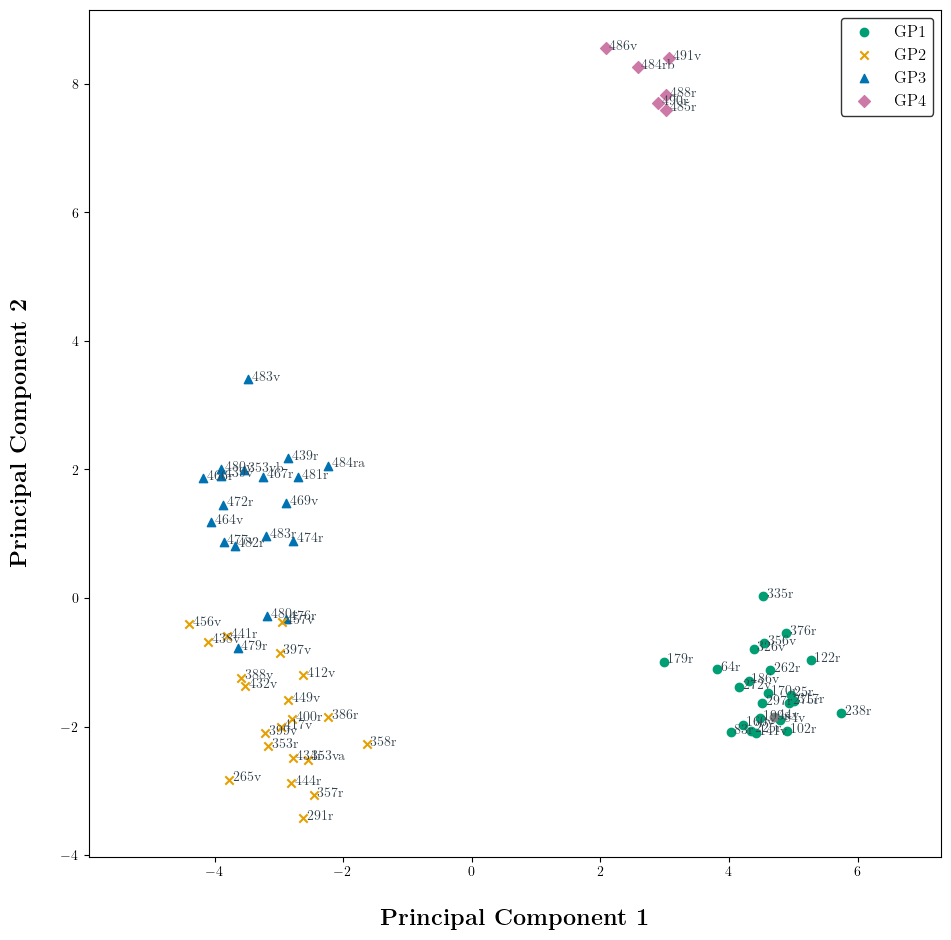

In [43]:
result_combined = pca_analysis(['a', 'd', 'g', 'm', 'o', 't'], 'all', prototype_folder, annotation_json_path, pca_dir)

# The save path for combined results
save_path = result_combined['save_dir']
char='combined'

# Save the prototypes for the combined characters
plot_pca_scatter(
    pca_result=result_combined['pca_model'].transform(result_combined['included_images']),  # PCA projections
    included_labels=result_combined['included_labels'],
    mapping=result_combined['folio_mapping'],
    images=result_combined['included_images'],
    image_shape=result_combined['image_shape'],
    components=(0, 1), 
    save_path=os.path.join(save_path, f"pca_scatter_{char}.png"),
    outliers=False,
    protos=False
)

## We proceed by defining the functions for our PCA analysis, alongside the 2D scatterplot: 

- **Scree (Variability) Plot**
- **Principal Component Analysis**
- **PC Variations/Gradation**
- **Sorting by Principal Component**

These functions correspond to the methodology described in Sections 6.1-6.3.

## Variability plot

In [33]:
def explained_variance_plot(pca, included_labels, folio_mapping, character, save_path):
    """
    Generates and saves the explained variance plot for PCA analysis.

    Args:
        pca (PCA object): The fitted PCA object.
        included_labels (list): List of labels corresponding to the images.
        folio_mapping (dict): Mapping from label to folio.
        character (str): The character being processed.
        save_dir (str): Directory where the plot will be saved.
    """
    # Explained variance (cumulative variance explained by the principal components)
    explained_variance_ratio = pca.explained_variance_ratio_

    # Plot the cumulative explained variance ratio
    plt.figure(figsize=(8, 6))
    plt.plot(np.cumsum(explained_variance_ratio), marker='o', linestyle='-', color='b')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title(f'Explained Variance for {character}')
    plt.grid(True)

    # Ensure the save directory exists
    os.makedirs(save_path, exist_ok=True)

    # Full save path for the variance plot
    save_path_variance_plot = os.path.join(save_path, f"explained_variance_plot_{character}.png")

    # Save the plot to the specified location
    plt.savefig(save_path_variance_plot, bbox_inches='tight')
    print(f"Explained variance plot saved to {save_path_variance_plot}")

    # Show the plot
    #plt.show()

## Principal Component Visualization

In [34]:
def plot_pca_components(mean_image, principal_components, explained_variance, image_shape, character, save_path):
    """
    Plots the mean image and the first four principal components with explained variance.
    Saves the figure to a specific directory named after the character.

    Args:
    - mean_image: The mean image to display.
    - principal_components: The first four principal components.
    - explained_variance: The explained variance ratios for the components.
    - image_shape: Shape of the images for proper reshaping during plotting.
    - character: The character folder name (e.g., 'a', 'b', 'c', etc.).
    - save_dir: The directory where the results should be saved.
    """
    cmap = LinearSegmentedColormap.from_list('custom_cmap', ['blue', 'white', 'red'], N=256)

    fig, ax = plt.subplots(1, 5, figsize=(15, 9)) 
    abs_max_list = [np.max(np.abs(pc)) for pc in principal_components[:4]]

    # Plot Mean Image
    ax[0].imshow(mean_image.reshape(image_shape), cmap='gray')
    ax[0].set_title(r'\textbf{M}', fontsize=17)
    ax[0].axis('off')

    # Plot the first 4 Principal Components with explained variance
    for i in range(4):
        abs_max = abs_max_list[i]
        ax[i + 1].imshow(principal_components[i].reshape(image_shape), cmap=cmap, vmin=-abs_max, vmax=abs_max)
        
        explained_var_percentage = explained_variance[i] * 100
        rounded_explained_var = math.ceil(explained_var_percentage * 10) / 10
        
        ax[i + 1].set_title(rf'\textbf{{PC{i + 1}}} \\ \textbf{{({rounded_explained_var:.1f}\%)}}', fontsize=17)
        ax[i + 1].axis('off')

    plt.tight_layout()

    # Ensure the save directory exists (Only the folder, not the file path)
    folder_path = os.path.dirname(save_path)
    os.makedirs(folder_path, exist_ok=True)

    # Save the plot directly as a PNG file inside the specified folder
    plt.savefig(save_path, bbox_inches='tight')
    print(f"PCA components plot saved to {save_path}")

    #plt.show()

## PCA variations - gradation

In [35]:
def plot_pca_variations(mean_image, principal_components, explained_variance, image_shape, component_indices=[0, 1], variation_factors=None, save_path=None, character=None):
    """
    Visualizes how adding/subtracting a principal component (or multiple components) affects the mean image.
    Additionally, saves full variation plot for each principal component.

    Args:
    - mean_image: The mean image.
    - principal_components: The principal components.
    - explained_variance: The explained variance for the components.
    - image_shape: Shape of the images.
    - component_indices: List of indices of the principal components to visualize (e.g., [0, 1] for PC1 and PC2).
    - variation_factors: List of factors to multiply the components by.
    - save_path: Directory to save the plot.
    - character: Folder name (e.g., 'a', 'b', 'c') for saving.
    """
    # Reshape the mean image to match the image shape
    mean_img_reshaped = mean_image.reshape(image_shape)
    
    # If variation factors are not provided, generate them based on the explained variance
    if variation_factors is None:
        variation_factors = [-3, -2, -1, 0, 1, 2, 3]  # Default variation factors

    # Set up the figure for plotting
    fig, axes = plt.subplots(1, len(variation_factors), figsize=(18, 5))
    
    # Loop through each component (PC1, PC2, etc.)
    for j, component_index in enumerate(component_indices):
        # Reshape the principal component
        pc_reshaped = principal_components[component_index].reshape(image_shape)

        # Loop through the variation factors and apply them to the mean image
        for i, factor in enumerate(variation_factors):
            # Generate the varied image
            varied_image = mean_img_reshaped + factor * pc_reshaped
            varied_image = np.clip(varied_image, 0, 1)

            # Plot the varied image for the current principal component
            axes[i].imshow(varied_image, cmap='gray')
            axes[i].set_title(fr'\textbf{{M {factor:+}}} $\lambda_{{{component_index + 1}}}$')
            axes[i].axis('off')

        # Add the title for the full variation plot of the current component (e.g., "PC1 Variations")
        plt.suptitle(f'PC{component_index + 1} Variations', fontsize=14)

        # Save the full variation plot for the current component (e.g., pc1_variations.png)
        if save_path:
            full_plot_path = os.path.join(save_path, f"pc{component_index + 1}_variations.png")
            plt.savefig(full_plot_path, bbox_inches='tight')
            print(f"Full variation plot for PC{component_index + 1} saved to {full_plot_path}")
    
    # Show the plot (optional)
    #plt.show()

## Prototypes sorted by PC

In [36]:
def show_images_by_component(images, labels, mapping, pca_result, component_index=0, save_path=None, image_shape=None):
    """
    Show images sorted by one or multiple PCA components and optionally save the images.

    Args:
        images: Flattened images.
        labels: Corresponding labels.
        mapping: Mapping from label to metadata.
        pca_result: PCA-transformed features.
        component_index: Single int or tuple/list of ints for PCA components.
        save_path: Base path to save the plots.
        image_shape: Shape to reshape flattened images.
    """
    if image_shape is None:
        raise ValueError("You must provide image_shape to reshape images for plotting.")
    
    # If a single integer is passed, make it a tuple
    if isinstance(component_index, int):
        component_indices = (component_index,)
    else:
        component_indices = component_index

    for idx in component_indices:
        image_label_pairs = [(images[i], labels[i], pca_result[i, idx]) for i in range(len(images))]
        image_label_pairs.sort(key=lambda x: x[2])

        sorted_images, sorted_labels, sorted_pca_values = zip(*image_label_pairs)

        num_images = len(sorted_images)
        fig, ax = plt.subplots(1, num_images, figsize=(60, 30))


        # In case there is only one image, make ax a list
        if num_images == 1:
            ax = [ax]

        for i in range(num_images):
            reshaped_image = sorted_images[i].reshape(image_shape)
            ax[i].imshow(reshaped_image, cmap='gray')
            label = sorted_labels[i]
            mapped_label = mapping.get(label, 'Unknown')
            pca_value = sorted_pca_values[i]
            ax[i].set_title(f'{mapped_label}\nPC{idx + 1}: {pca_value:.2f}')
            ax[i].axis('off')

        if save_path:
            # Adjust save path for each component
            save_dir = os.path.dirname(save_path)
            base_name = os.path.splitext(os.path.basename(save_path))[0]
            ext = os.path.splitext(save_path)[1]
            save_path_component = os.path.join(save_dir, f"{base_name}_PC{idx+1}{ext}")
            
            os.makedirs(os.path.dirname(save_path_component), exist_ok=True)
            plt.savefig(save_path_component, bbox_inches='tight')
            print(f"Images sorted by PC{idx+1} saved to {save_path_component}")

        plt.show()

## We now apply all of these functions to the chosen characters separately. 

The results are saved in the `./results/graphic_profiles` folder, and correspond to all the Figures in Section 7.1.2 of the article.

Running PCA separately for characters: ['a', 'd', 'g', 'm', 'o', 't']
Running PCA for character: a
Parsed image name: [26]
PCA results saved for character a
Running PCA for character: d
Parsed image name: [29]
PCA results saved for character d
Running PCA for character: g
Parsed image name: [32]
PCA results saved for character g
Running PCA for character: m
Parsed image name: [37]
PCA results saved for character m
Running PCA for character: o
Parsed image name: [39]
PCA results saved for character o
Running PCA for character: t
Parsed image name: [44]
PCA results saved for character t
Image saved to /Users/vlachou/Desktop/zenodo/hand-variability-analysis/notebooks/../results/graphic_profiles/a/selected_pca_samples_a.png
Explained variance plot saved to /Users/vlachou/Desktop/zenodo/hand-variability-analysis/notebooks/../results/graphic_profiles/a/explained_variance_plot_a.png
PCA components plot saved to /Users/vlachou/Desktop/zenodo/hand-variability-analysis/notebooks/../results/graph

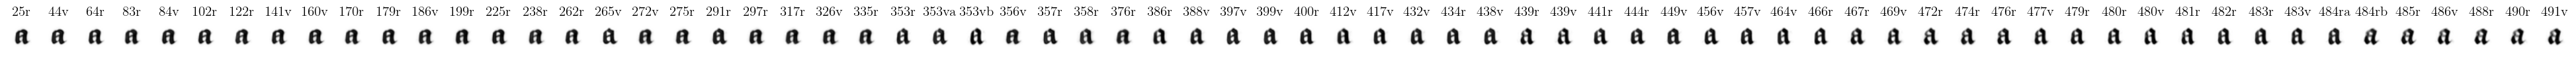

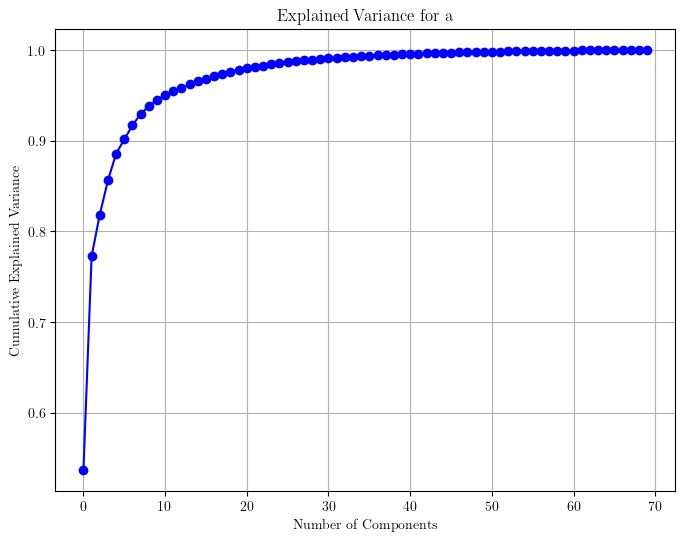

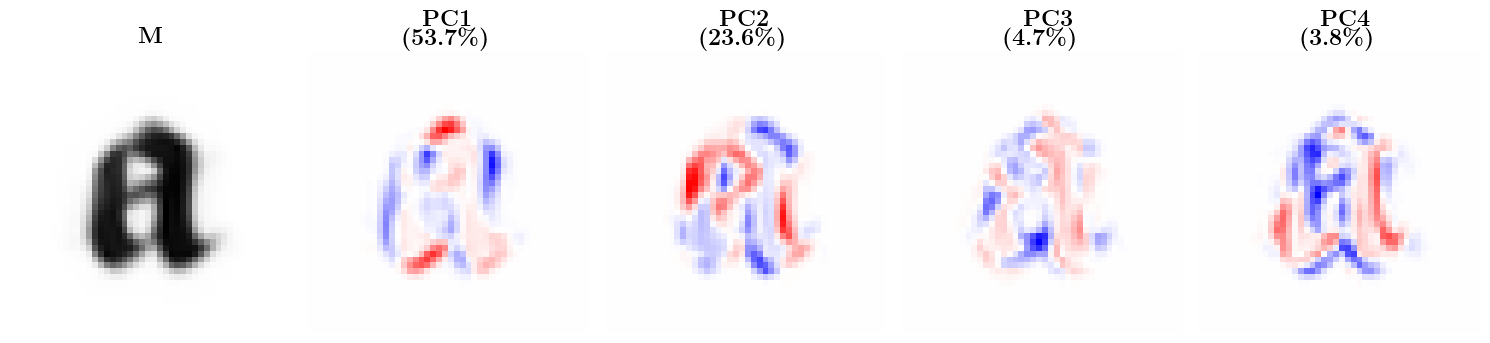

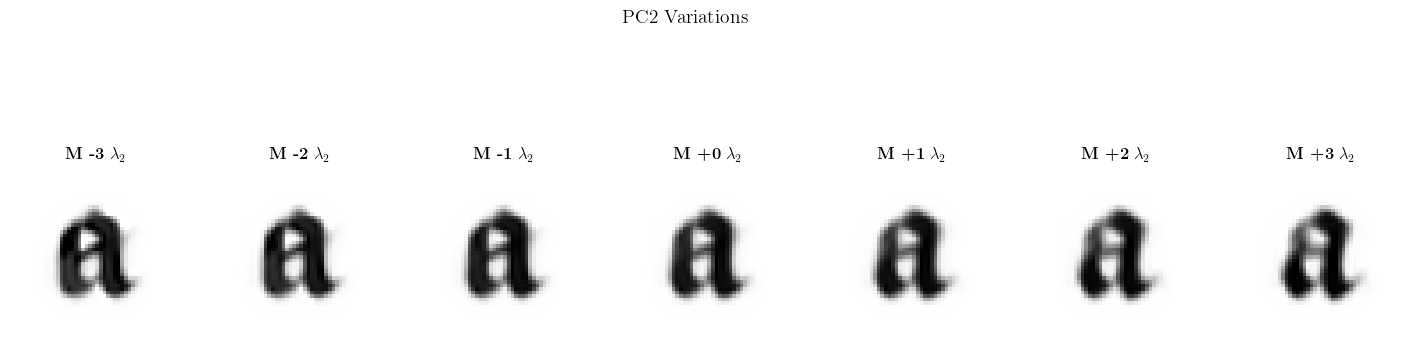

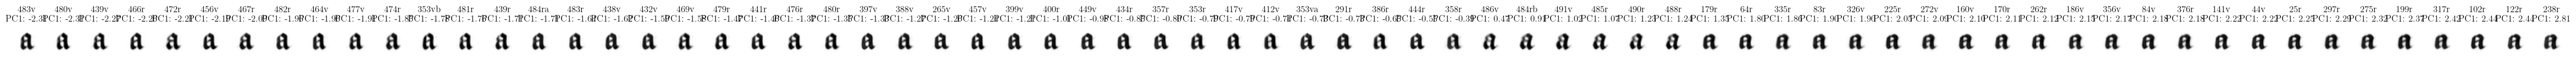

Images sorted by PC2 saved to /Users/vlachou/Desktop/zenodo/hand-variability-analysis/notebooks/../results/graphic_profiles/a/a_sorted_by_PC2.png


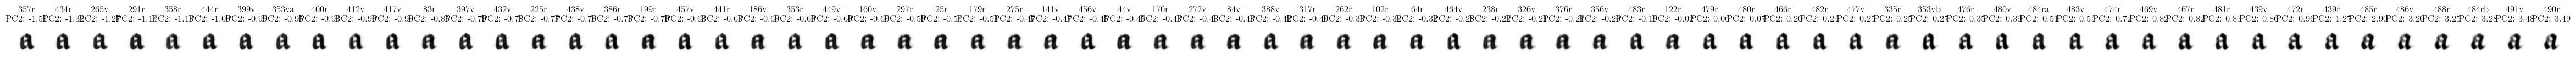

PCA scatter plot saved to /Users/vlachou/Desktop/zenodo/hand-variability-analysis/notebooks/../results/graphic_profiles/a/pca_scatter_a.png


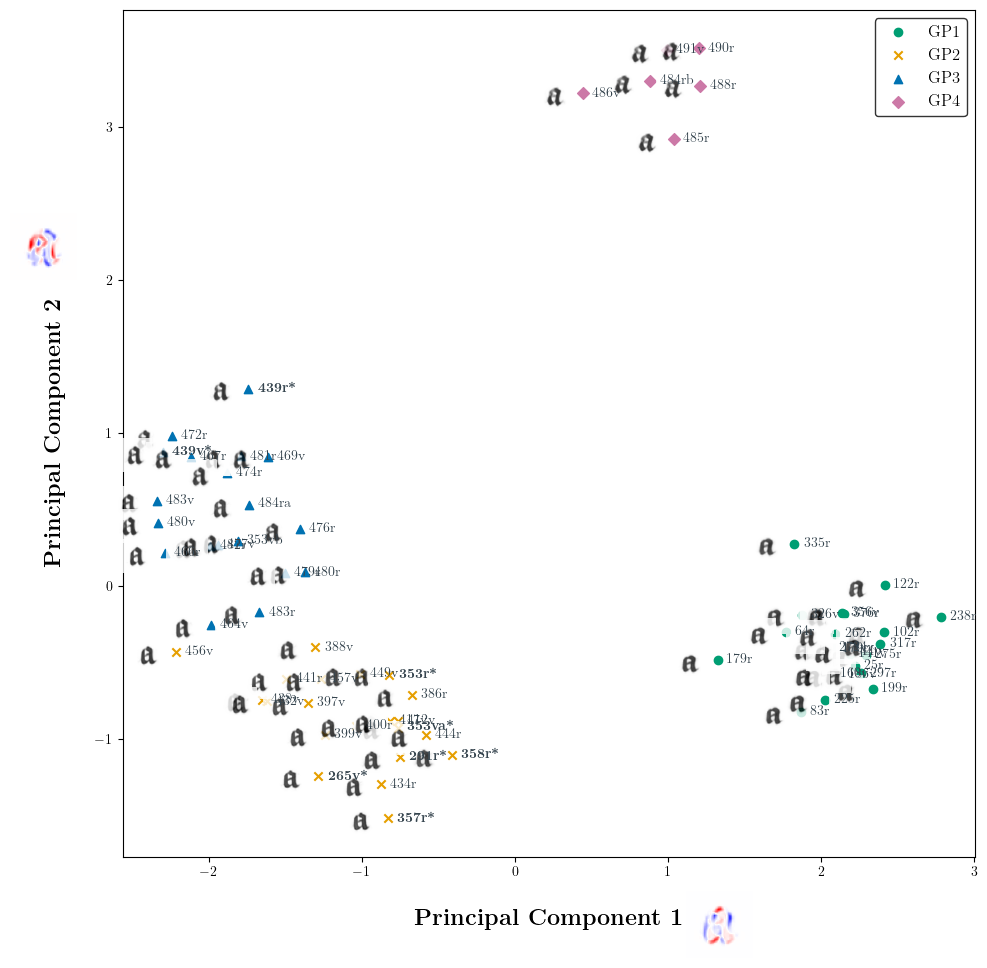

Image saved to /Users/vlachou/Desktop/zenodo/hand-variability-analysis/notebooks/../results/graphic_profiles/d/selected_pca_samples_d.png
Explained variance plot saved to /Users/vlachou/Desktop/zenodo/hand-variability-analysis/notebooks/../results/graphic_profiles/d/explained_variance_plot_d.png
PCA components plot saved to /Users/vlachou/Desktop/zenodo/hand-variability-analysis/notebooks/../results/graphic_profiles/d/mean_and_components_d.png
Full variation plot for PC1 saved to /Users/vlachou/Desktop/zenodo/hand-variability-analysis/notebooks/../results/graphic_profiles/d/pc1_variations.png
Full variation plot for PC2 saved to /Users/vlachou/Desktop/zenodo/hand-variability-analysis/notebooks/../results/graphic_profiles/d/pc2_variations.png
Images sorted by PC1 saved to /Users/vlachou/Desktop/zenodo/hand-variability-analysis/notebooks/../results/graphic_profiles/d/d_sorted_by_PC1.png


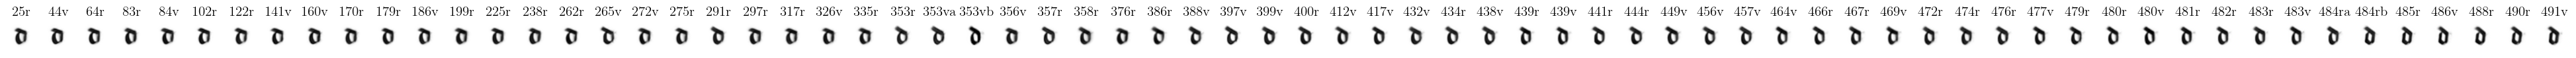

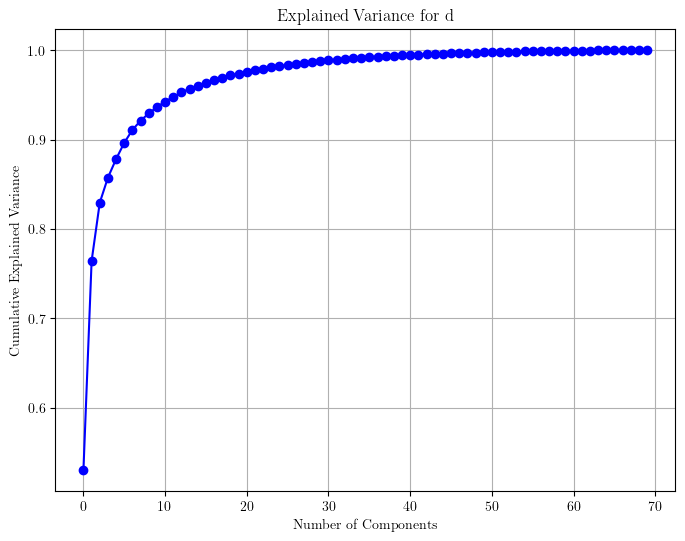

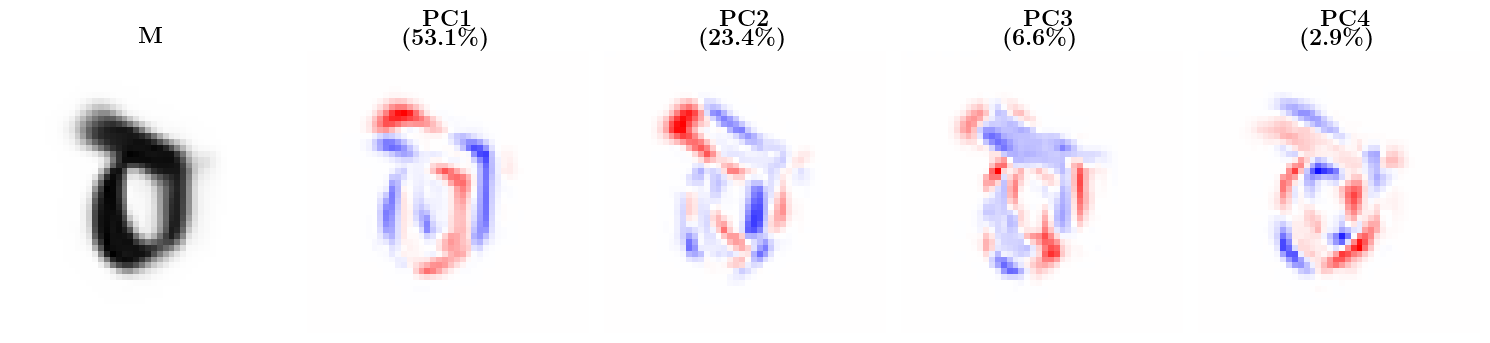

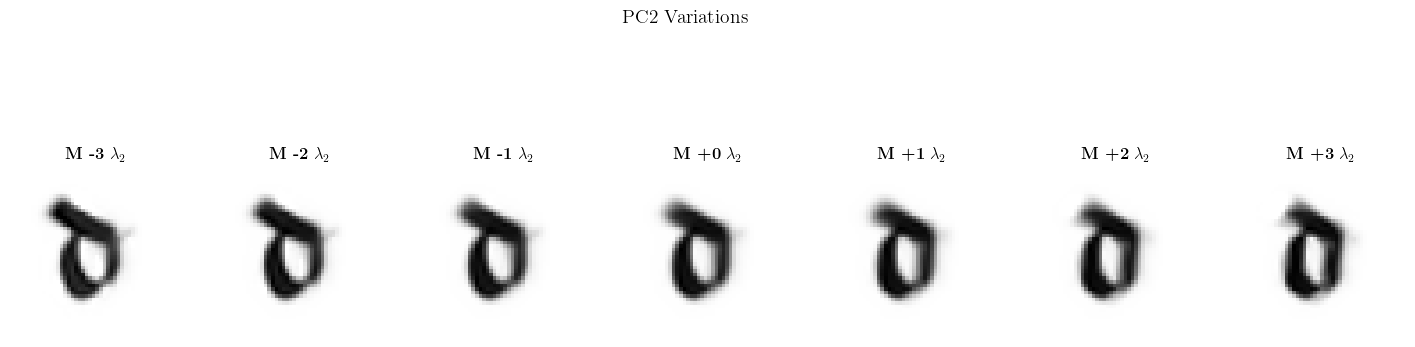

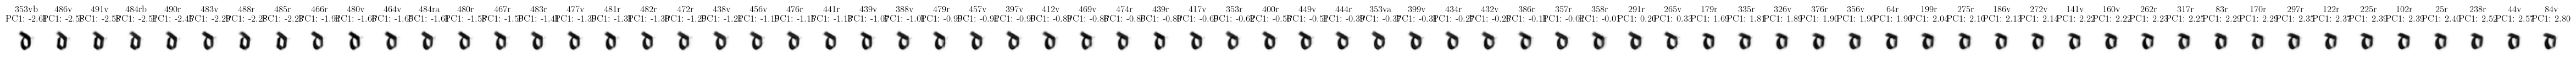

Images sorted by PC2 saved to /Users/vlachou/Desktop/zenodo/hand-variability-analysis/notebooks/../results/graphic_profiles/d/d_sorted_by_PC2.png


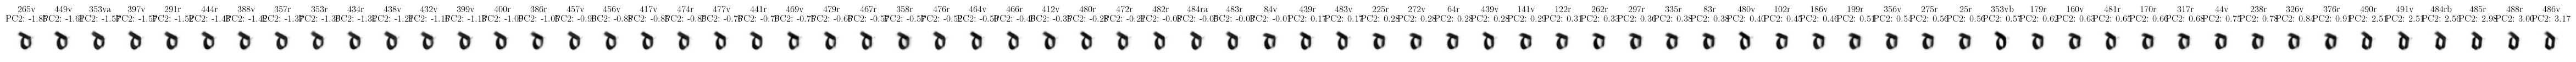

PCA scatter plot saved to /Users/vlachou/Desktop/zenodo/hand-variability-analysis/notebooks/../results/graphic_profiles/d/pca_scatter_d.png


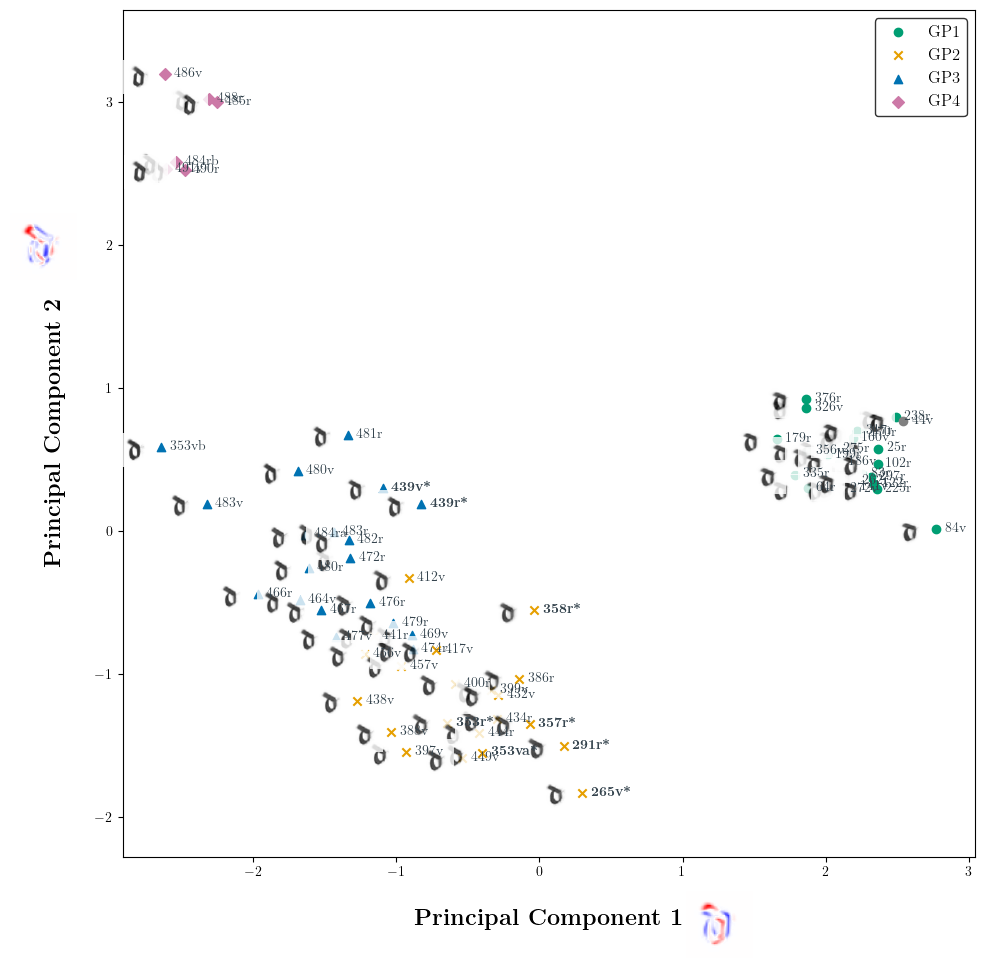

Image saved to /Users/vlachou/Desktop/zenodo/hand-variability-analysis/notebooks/../results/graphic_profiles/g/selected_pca_samples_g.png
Explained variance plot saved to /Users/vlachou/Desktop/zenodo/hand-variability-analysis/notebooks/../results/graphic_profiles/g/explained_variance_plot_g.png
PCA components plot saved to /Users/vlachou/Desktop/zenodo/hand-variability-analysis/notebooks/../results/graphic_profiles/g/mean_and_components_g.png
Full variation plot for PC1 saved to /Users/vlachou/Desktop/zenodo/hand-variability-analysis/notebooks/../results/graphic_profiles/g/pc1_variations.png
Full variation plot for PC2 saved to /Users/vlachou/Desktop/zenodo/hand-variability-analysis/notebooks/../results/graphic_profiles/g/pc2_variations.png
Images sorted by PC1 saved to /Users/vlachou/Desktop/zenodo/hand-variability-analysis/notebooks/../results/graphic_profiles/g/g_sorted_by_PC1.png


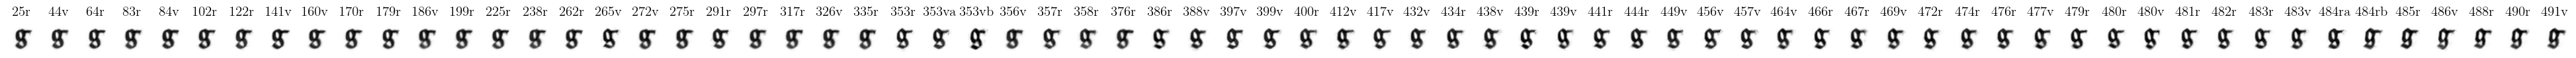

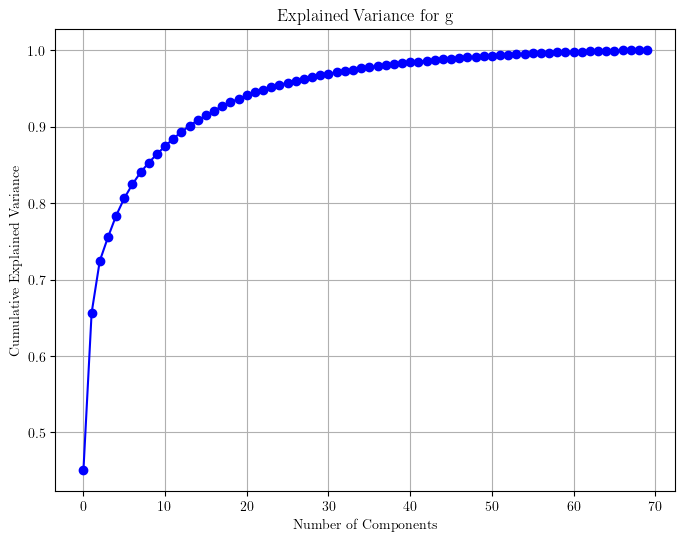

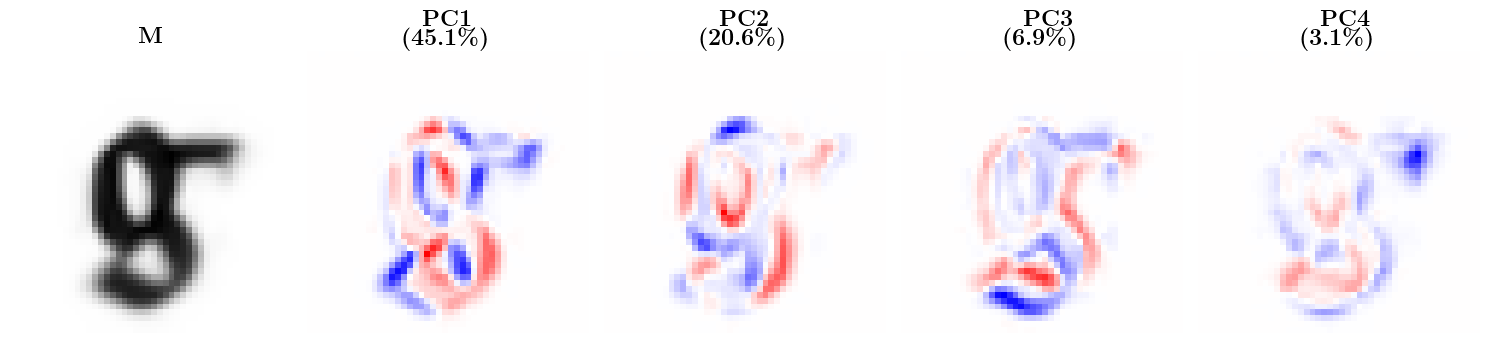

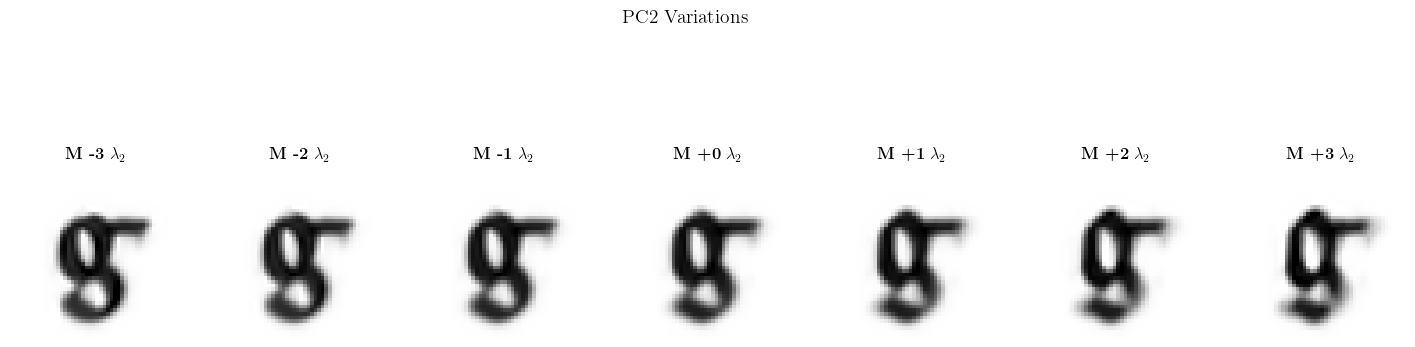

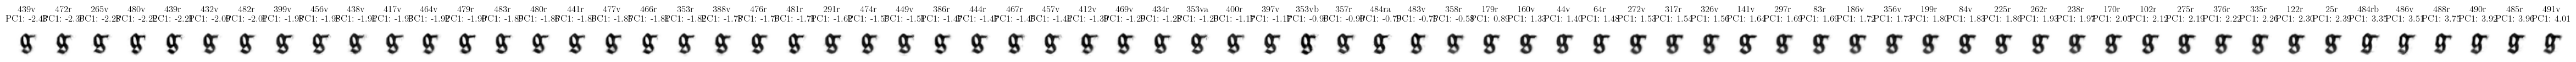

Images sorted by PC2 saved to /Users/vlachou/Desktop/zenodo/hand-variability-analysis/notebooks/../results/graphic_profiles/g/g_sorted_by_PC2.png


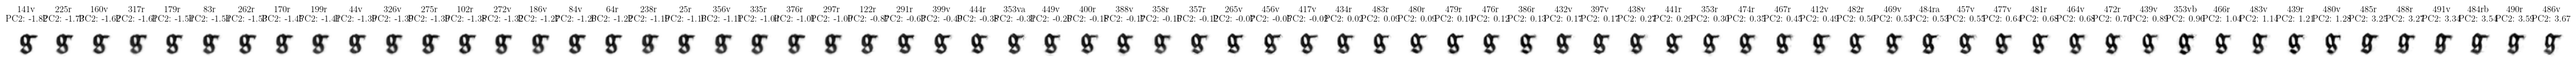

PCA scatter plot saved to /Users/vlachou/Desktop/zenodo/hand-variability-analysis/notebooks/../results/graphic_profiles/g/pca_scatter_g.png


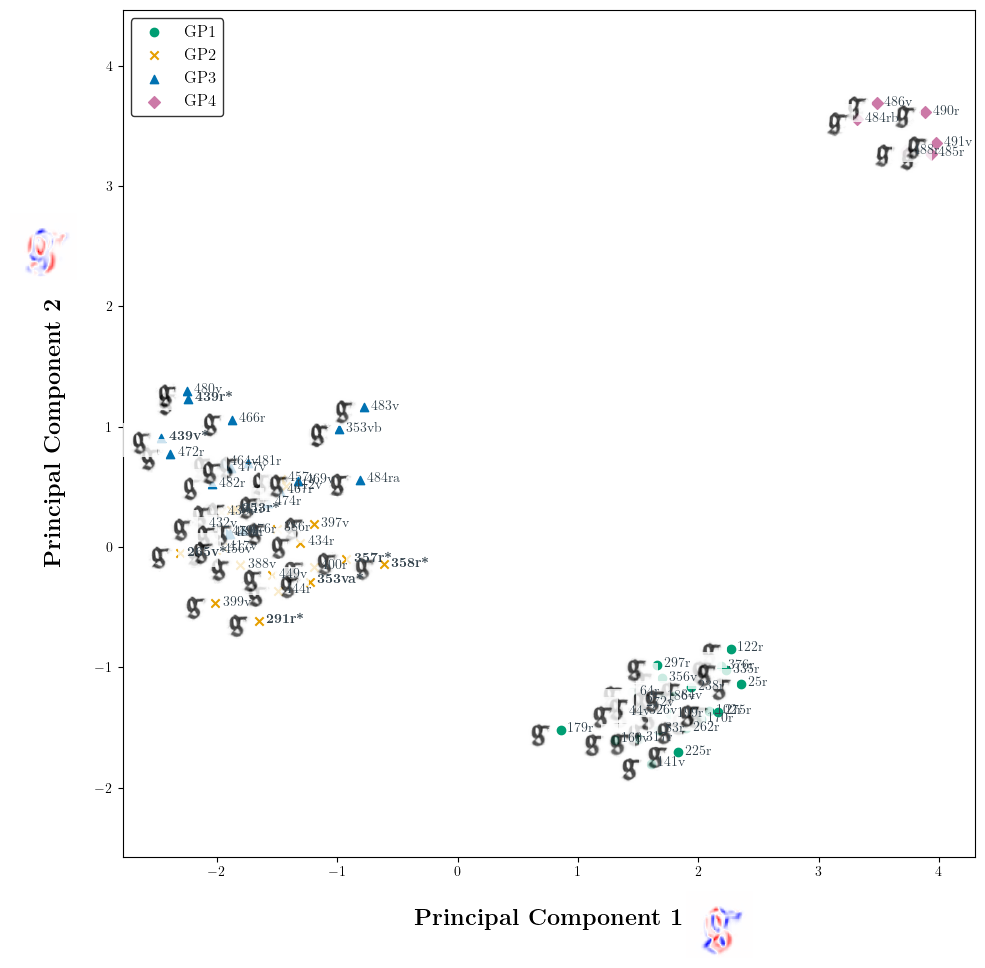

Image saved to /Users/vlachou/Desktop/zenodo/hand-variability-analysis/notebooks/../results/graphic_profiles/m/selected_pca_samples_m.png
Explained variance plot saved to /Users/vlachou/Desktop/zenodo/hand-variability-analysis/notebooks/../results/graphic_profiles/m/explained_variance_plot_m.png
PCA components plot saved to /Users/vlachou/Desktop/zenodo/hand-variability-analysis/notebooks/../results/graphic_profiles/m/mean_and_components_m.png
Full variation plot for PC1 saved to /Users/vlachou/Desktop/zenodo/hand-variability-analysis/notebooks/../results/graphic_profiles/m/pc1_variations.png
Full variation plot for PC2 saved to /Users/vlachou/Desktop/zenodo/hand-variability-analysis/notebooks/../results/graphic_profiles/m/pc2_variations.png
Images sorted by PC1 saved to /Users/vlachou/Desktop/zenodo/hand-variability-analysis/notebooks/../results/graphic_profiles/m/m_sorted_by_PC1.png


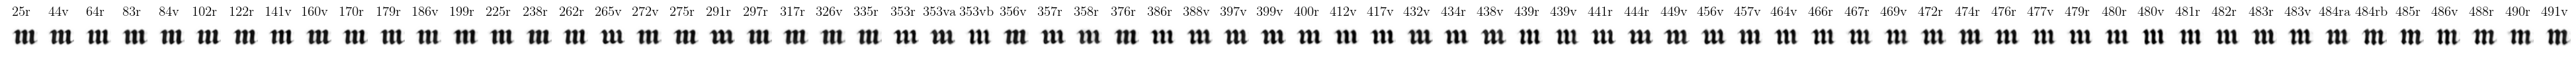

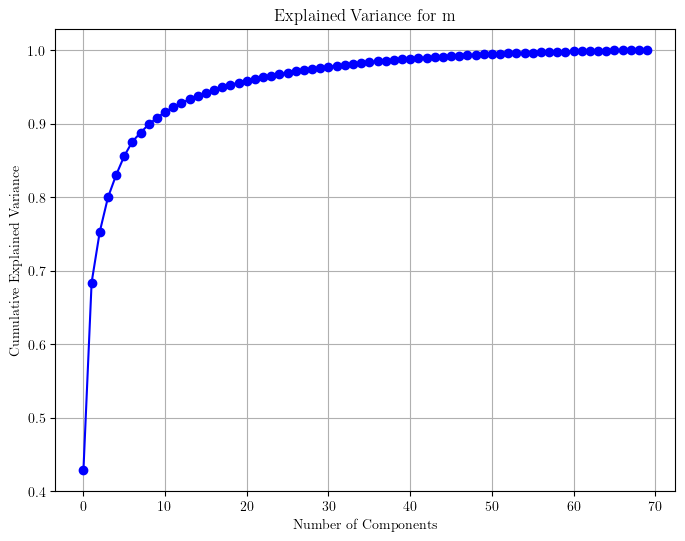

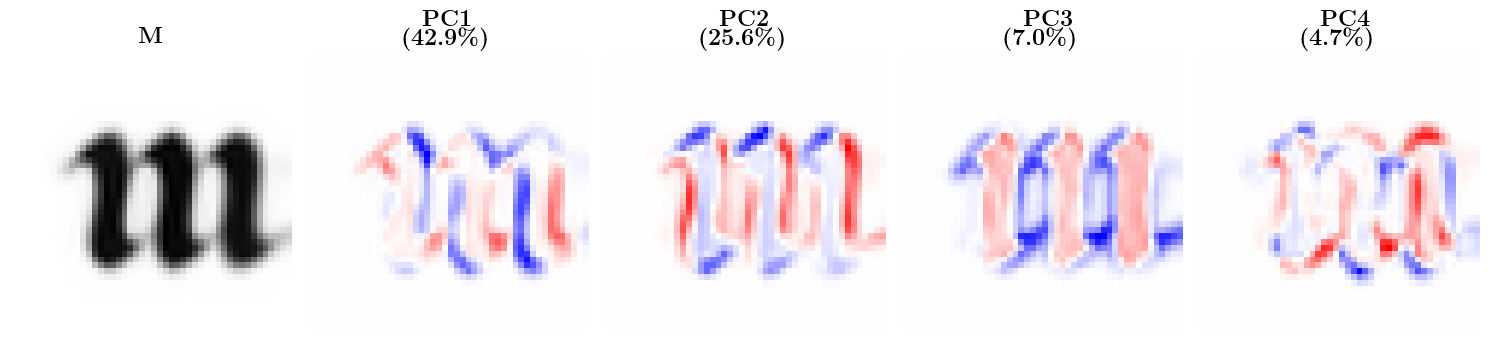

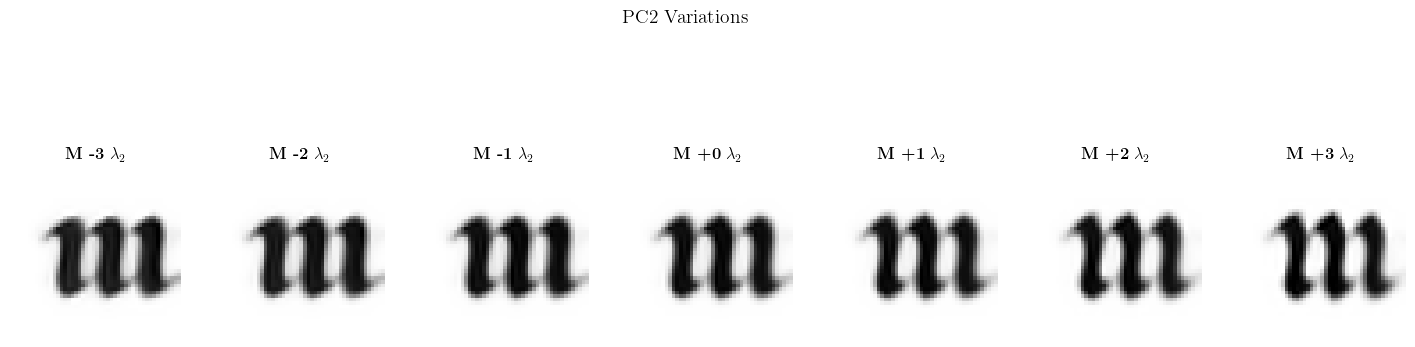

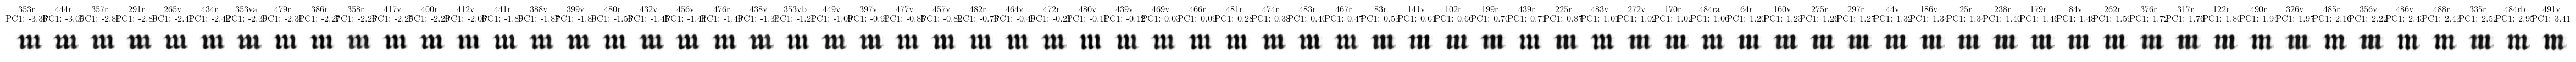

Images sorted by PC2 saved to /Users/vlachou/Desktop/zenodo/hand-variability-analysis/notebooks/../results/graphic_profiles/m/m_sorted_by_PC2.png


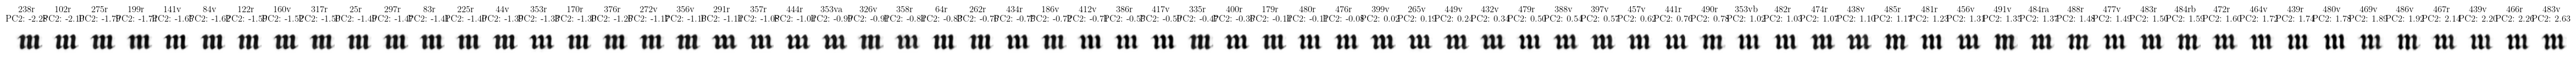

PCA scatter plot saved to /Users/vlachou/Desktop/zenodo/hand-variability-analysis/notebooks/../results/graphic_profiles/m/pca_scatter_m.png


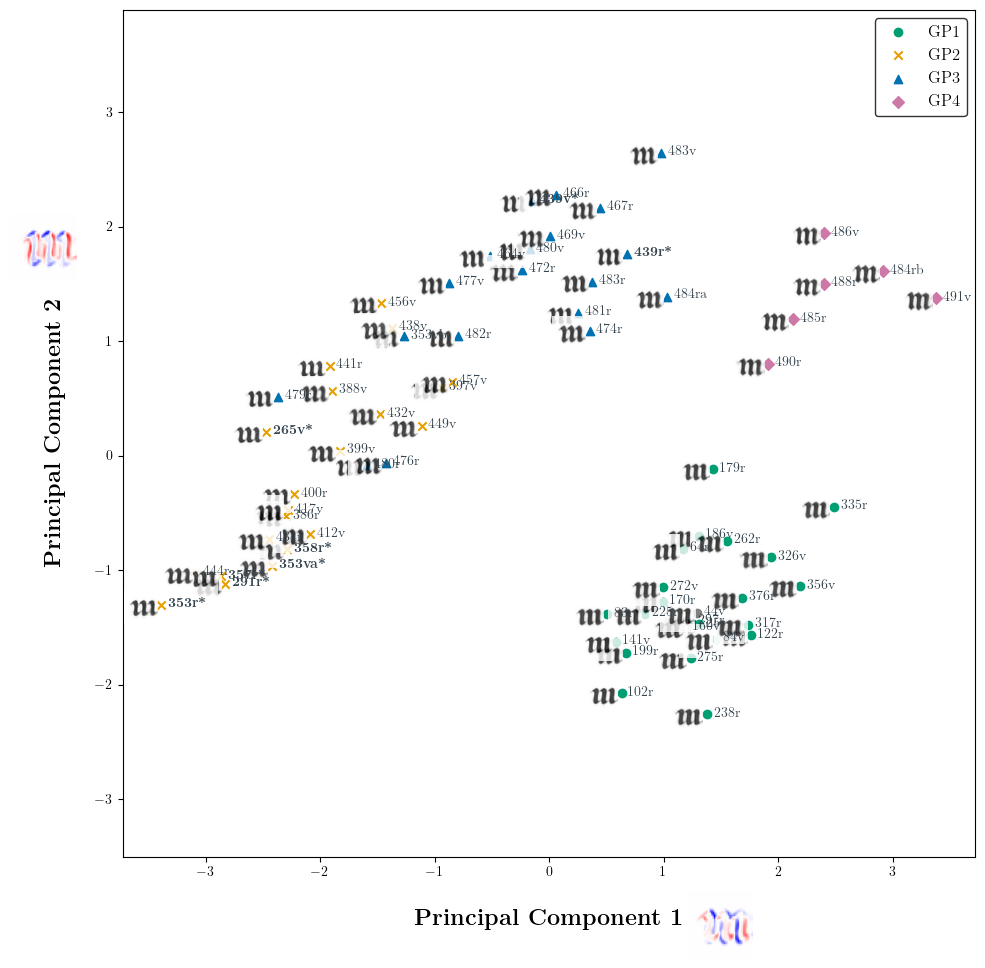

Image saved to /Users/vlachou/Desktop/zenodo/hand-variability-analysis/notebooks/../results/graphic_profiles/o/selected_pca_samples_o.png
Explained variance plot saved to /Users/vlachou/Desktop/zenodo/hand-variability-analysis/notebooks/../results/graphic_profiles/o/explained_variance_plot_o.png
PCA components plot saved to /Users/vlachou/Desktop/zenodo/hand-variability-analysis/notebooks/../results/graphic_profiles/o/mean_and_components_o.png
Full variation plot for PC1 saved to /Users/vlachou/Desktop/zenodo/hand-variability-analysis/notebooks/../results/graphic_profiles/o/pc1_variations.png
Full variation plot for PC2 saved to /Users/vlachou/Desktop/zenodo/hand-variability-analysis/notebooks/../results/graphic_profiles/o/pc2_variations.png
Images sorted by PC1 saved to /Users/vlachou/Desktop/zenodo/hand-variability-analysis/notebooks/../results/graphic_profiles/o/o_sorted_by_PC1.png


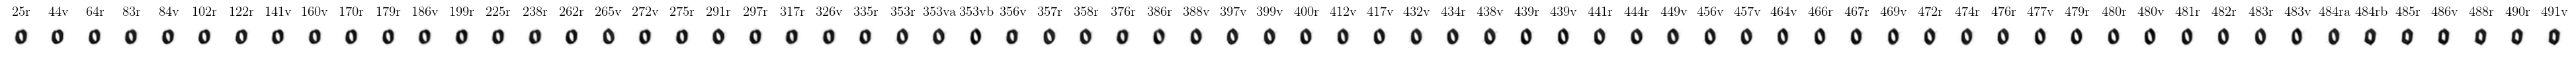

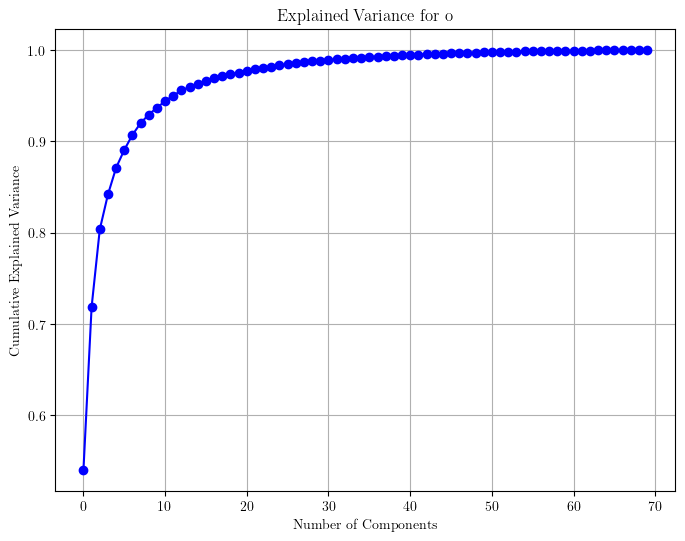

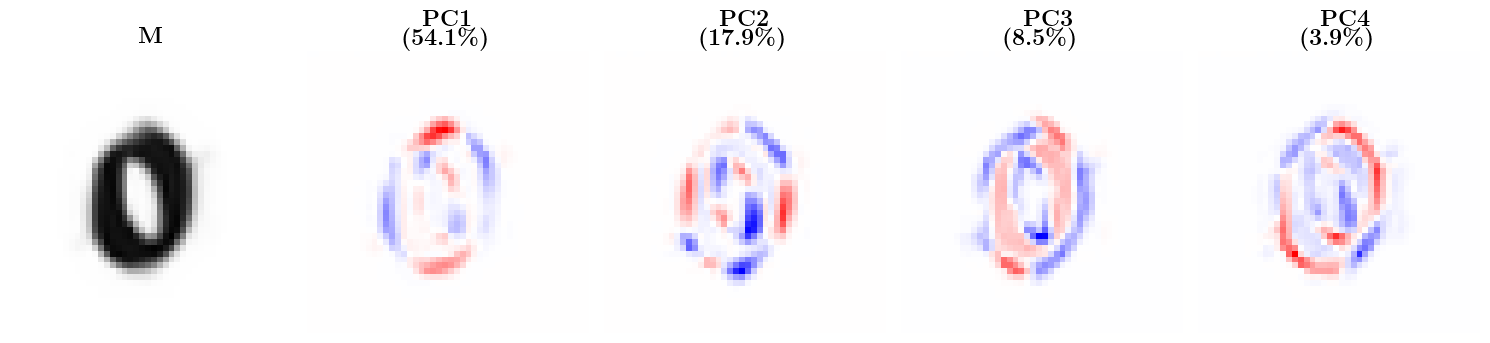

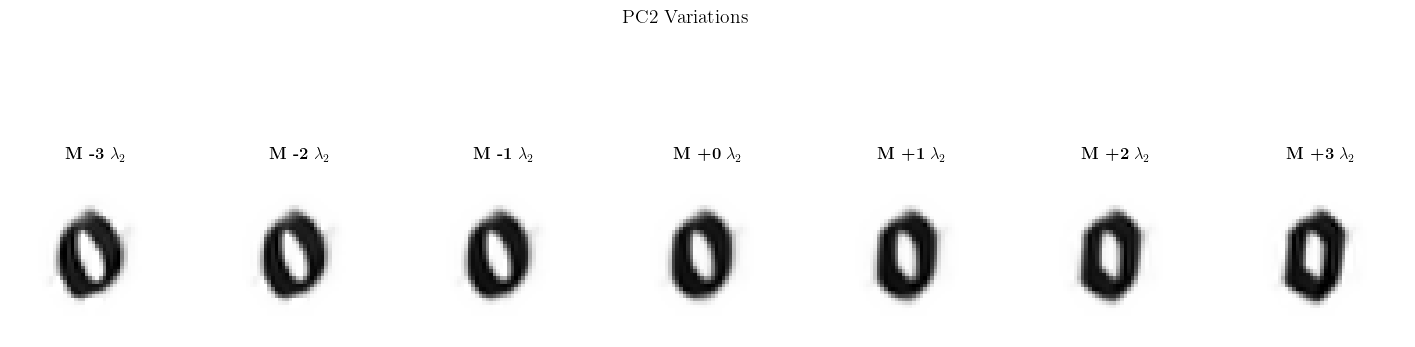

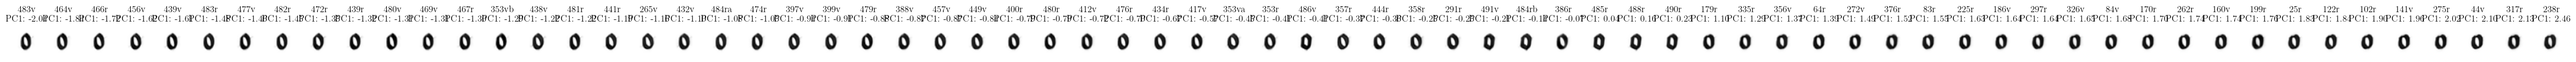

Images sorted by PC2 saved to /Users/vlachou/Desktop/zenodo/hand-variability-analysis/notebooks/../results/graphic_profiles/o/o_sorted_by_PC2.png


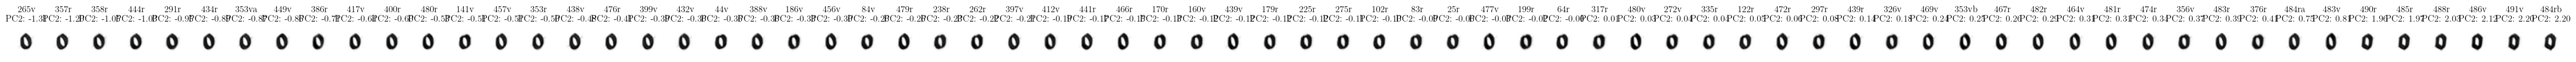

PCA scatter plot saved to /Users/vlachou/Desktop/zenodo/hand-variability-analysis/notebooks/../results/graphic_profiles/o/pca_scatter_o.png


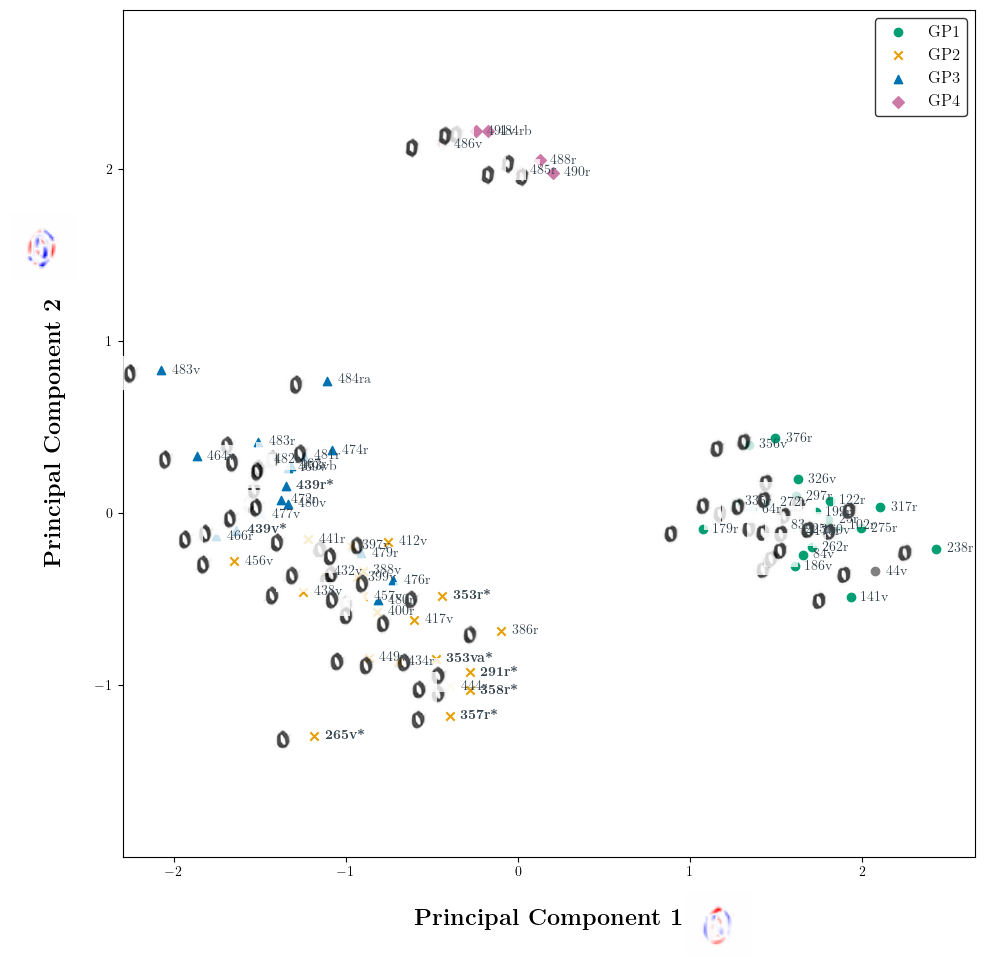

Image saved to /Users/vlachou/Desktop/zenodo/hand-variability-analysis/notebooks/../results/graphic_profiles/t/selected_pca_samples_t.png
Explained variance plot saved to /Users/vlachou/Desktop/zenodo/hand-variability-analysis/notebooks/../results/graphic_profiles/t/explained_variance_plot_t.png
PCA components plot saved to /Users/vlachou/Desktop/zenodo/hand-variability-analysis/notebooks/../results/graphic_profiles/t/mean_and_components_t.png
Full variation plot for PC1 saved to /Users/vlachou/Desktop/zenodo/hand-variability-analysis/notebooks/../results/graphic_profiles/t/pc1_variations.png
Full variation plot for PC2 saved to /Users/vlachou/Desktop/zenodo/hand-variability-analysis/notebooks/../results/graphic_profiles/t/pc2_variations.png
Images sorted by PC1 saved to /Users/vlachou/Desktop/zenodo/hand-variability-analysis/notebooks/../results/graphic_profiles/t/t_sorted_by_PC1.png


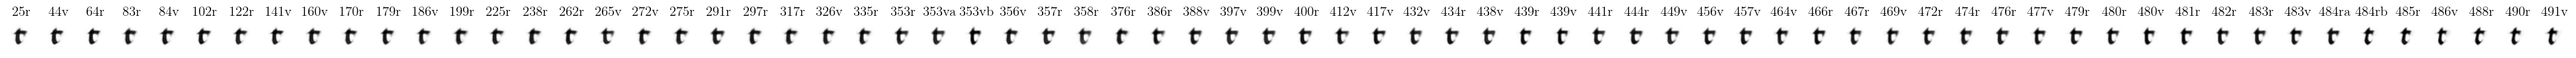

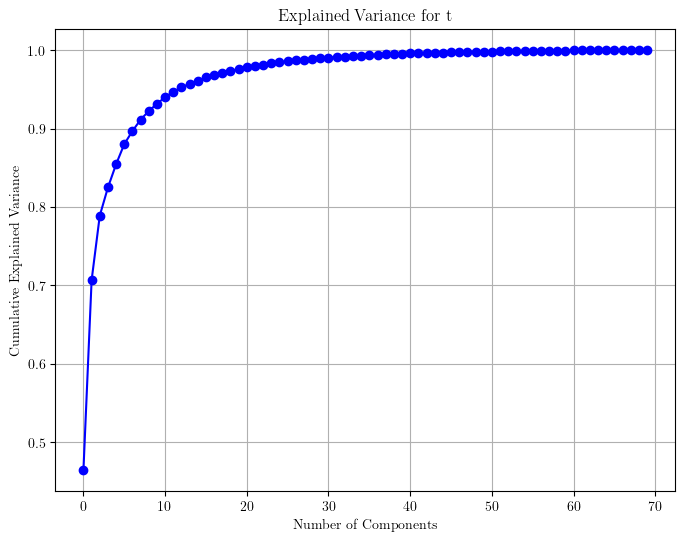

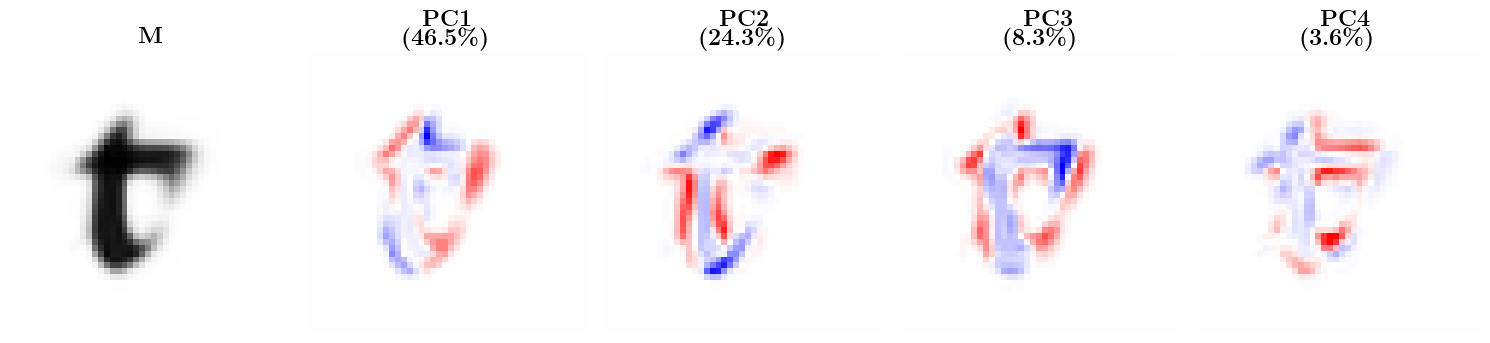

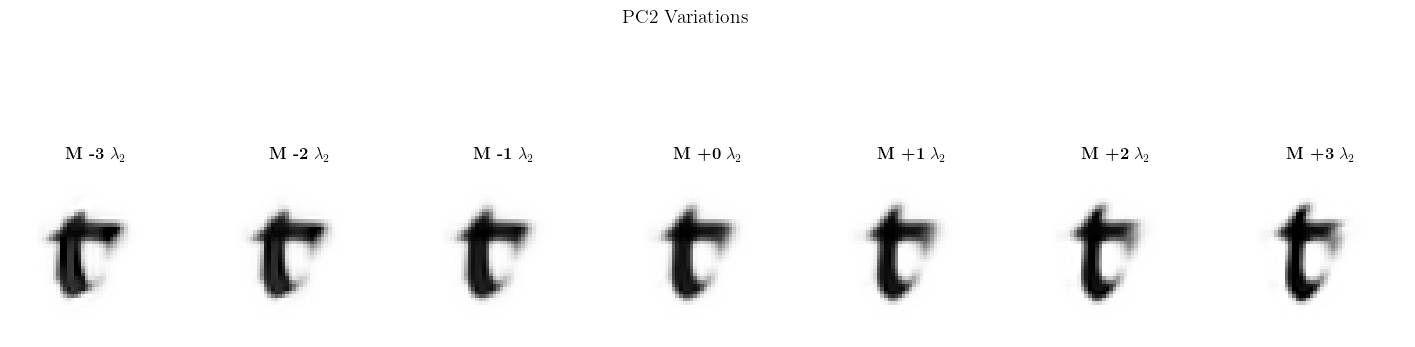

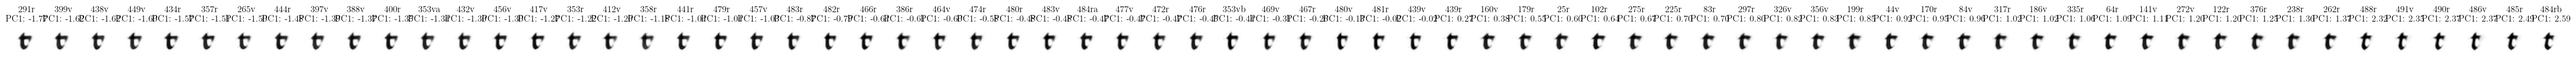

Images sorted by PC2 saved to /Users/vlachou/Desktop/zenodo/hand-variability-analysis/notebooks/../results/graphic_profiles/t/t_sorted_by_PC2.png


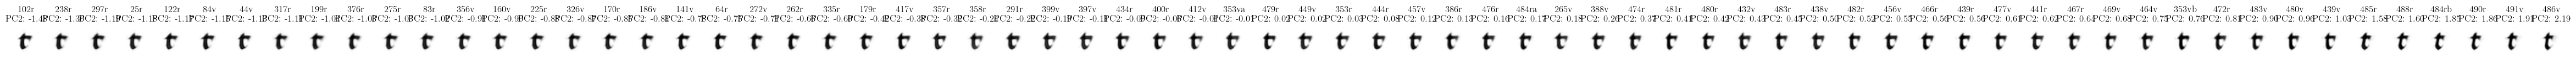

PCA scatter plot saved to /Users/vlachou/Desktop/zenodo/hand-variability-analysis/notebooks/../results/graphic_profiles/t/pca_scatter_t.png


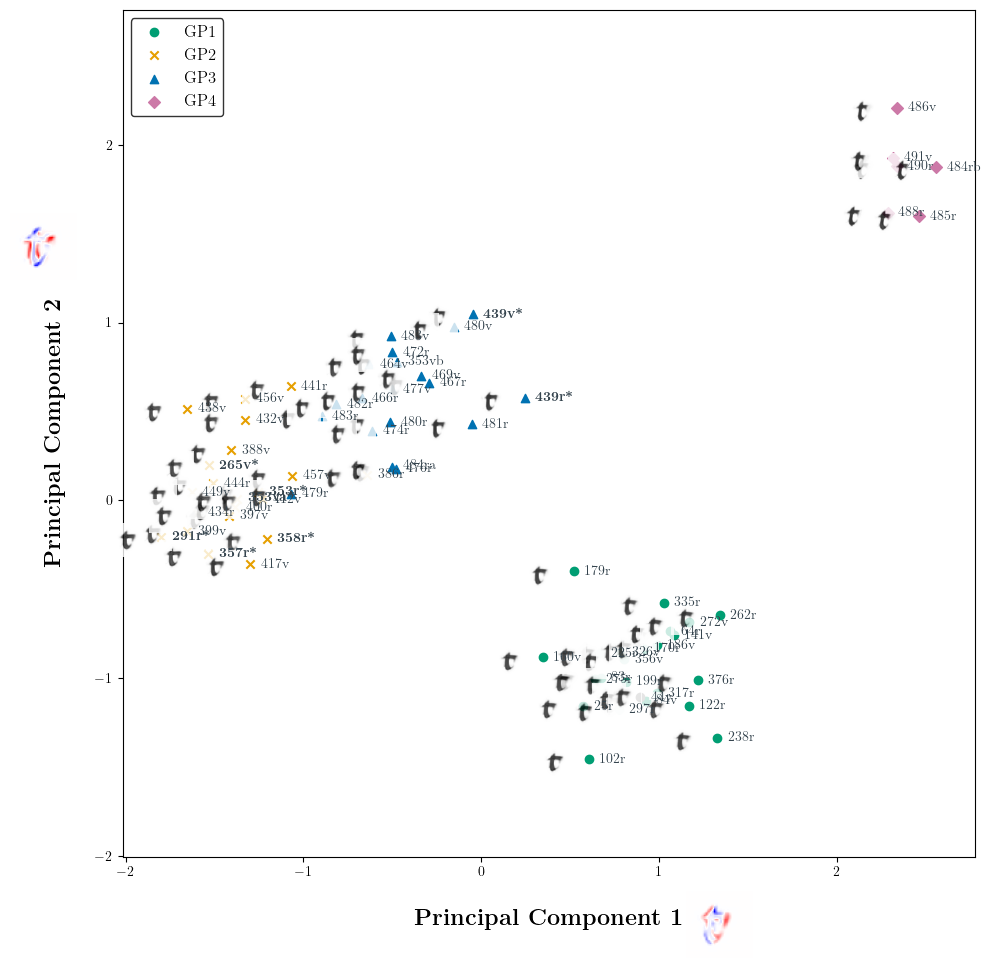

In [44]:
results_separate = pca_analysis(['a', 'd', 'g', 'm', 'o', 't'], 'separate', prototype_folder, annotation_json_path, pca_dir)

for char, result in results_separate.items():
    save_path = result['save_dir']
    
    # Save the prototypes for each individual character
    pca_prototypes(result['included_images'], result['included_labels'], result['folio_mapping'], save_path=os.path.join(save_path, f"selected_pca_samples_{char}.png"))
    
    # Generate and save the explained variance plot for each character
    explained_variance_plot(result['pca_model'], result['included_labels'], result['folio_mapping'], char, save_path=save_path)
    
    # Plot and save the PCA components for each character
    plot_pca_components(
        mean_image=result['pca_model'].mean_,
        principal_components=result['pca_model'].components_[:4],
        explained_variance=result['pca_model'].explained_variance_ratio_[:4],
        image_shape=result['image_shape'],
        character=char,
        save_path=os.path.join(save_path, f"mean_and_components_{char}.png")
    )
    
    plot_pca_variations(
        mean_image=result['pca_model'].mean_,
        principal_components=result['pca_model'].components_[:4],
        explained_variance=result['pca_model'].explained_variance_ratio_[:4],
        image_shape=result['image_shape'],
        character=char,
        component_indices=[0, 1],
        save_path=save_path,
    )
    
    show_images_by_component(
        images=result['included_images'],
        labels=result['included_labels'],
        mapping=result['folio_mapping'],
        pca_result=result['pca_model'].transform(result['included_images']),
        component_index=(0, 1),
        save_path=os.path.join(save_path, f"{char}_sorted_by.png"),
        image_shape=result['image_shape'],
    )
    
    principal_components = result['pca_model'].components_[:4].reshape(-1, *result['image_shape'])
    plot_pca_scatter(
        pca_result=result['pca_model'].transform(result['included_images']),
        included_labels=result['included_labels'],
        mapping=result['folio_mapping'],
        images=result['included_images'],
        image_shape=result['image_shape'],
        components=(0, 1), 
        save_path=os.path.join(save_path, f"pca_scatter_{char}.png"),
        outliers=True,
        protos=True,
        principal_components=principal_components
    )